Comparing the performance of fake review classification for a handufull of different classifiers while using the bag of word or TG-IDF text representation methods. 

In [58]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings


seed = 3765

In [6]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download("punkt")

lemmatizer = nltk.WordNetLemmatizer()
bagOfWordsVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\emiln\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\emiln\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emiln\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiln\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
dataFrame = pd.read_csv('fake reviews dataset.csv', names=['category', 'rating', 'label', 'reviewText'])
#Drop the first row
dataFrame = dataFrame.iloc[1:]
dataFrame.shape

(40432, 4)

In [29]:
dataFrame.head()

,category,rating,label,reviewText
1,Home_and_Kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
2,Home_and_Kitchen,5.0,CG,"love it, a great upgrade from the original. I..."
3,Home_and_Kitchen,5.0,CG,This pillow saved my back. I love the look and...
4,Home_and_Kitchen,1.0,CG,"Missing information on how to use it, but it i..."
5,Home_and_Kitchen,5.0,CG,Very nice set. Good quality. We have had the s...


In [30]:
print("Number of NaN values in each column")
dataFrame.isnull().sum()

Number of NaN values in each column


category      0
rating        0
label         0
reviewText    0
dtype: int64

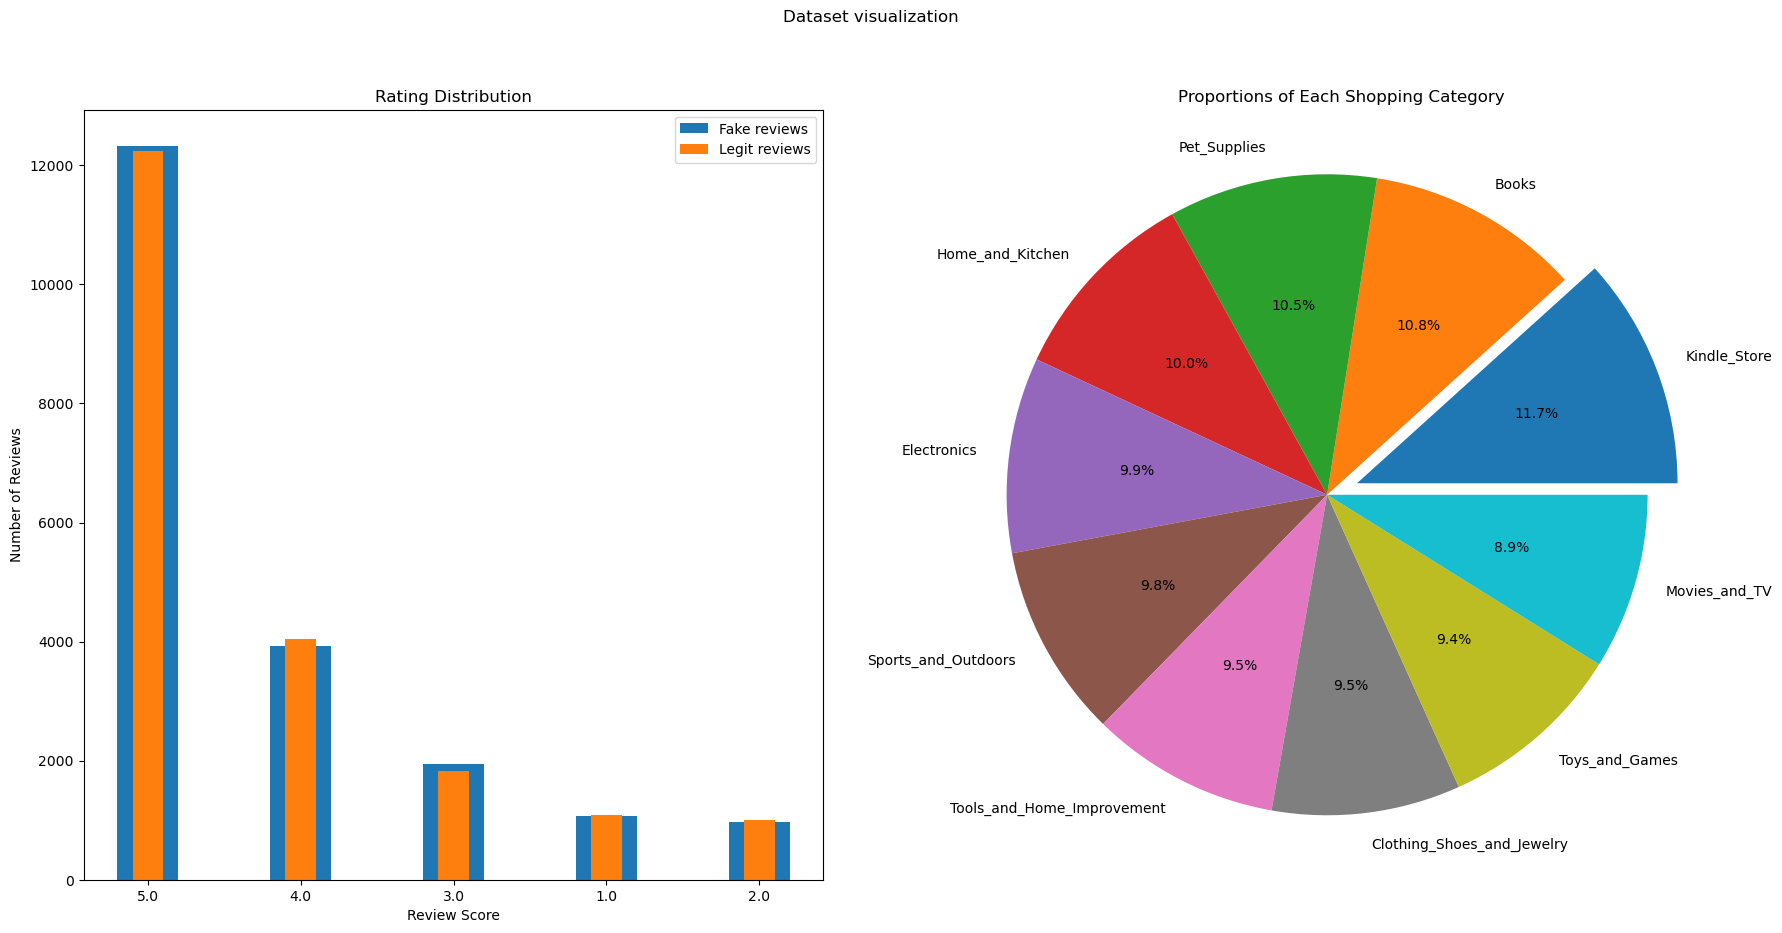

<Figure size 4000x2000 with 0 Axes>

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(21, 10))
plt.figure(figsize=(40,20))
fig.suptitle("Dataset visualization")

labelsRating = dataFrame["rating"].value_counts().keys()
valuesRatingFakeReviews = dataFrame["rating"].loc[dataFrame["label"] == "CG"].value_counts().values
valuesRatingLegitReviews = dataFrame["rating"].loc[dataFrame["label"] == "OR"].value_counts().values
axs[0].set_title("Rating Distribution")
axs[0].set_xlabel("Review Score")
axs[0].set_ylabel("Number of Reviews")
axs[0].bar(labelsRating, valuesRatingFakeReviews, width=0.4, label="Fake reviews")
axs[0].bar(labelsRating, valuesRatingLegitReviews, width=0.2, label="Legit reviews")
axs[0].legend()

labelsCategory = dataFrame["category"].value_counts().keys()
valuesCategory = dataFrame["category"].value_counts().values
explodeArr = [0.1,0,0,0,0,0,0,0,0,0] 
axs[1].set_title("Proportions of Each Shopping Category")
axs[1].pie(valuesCategory, labels=labelsCategory, explode=explodeArr, autopct='%1.1f%%', shadow=False)
axs[1].axis("equal")

plt.show()

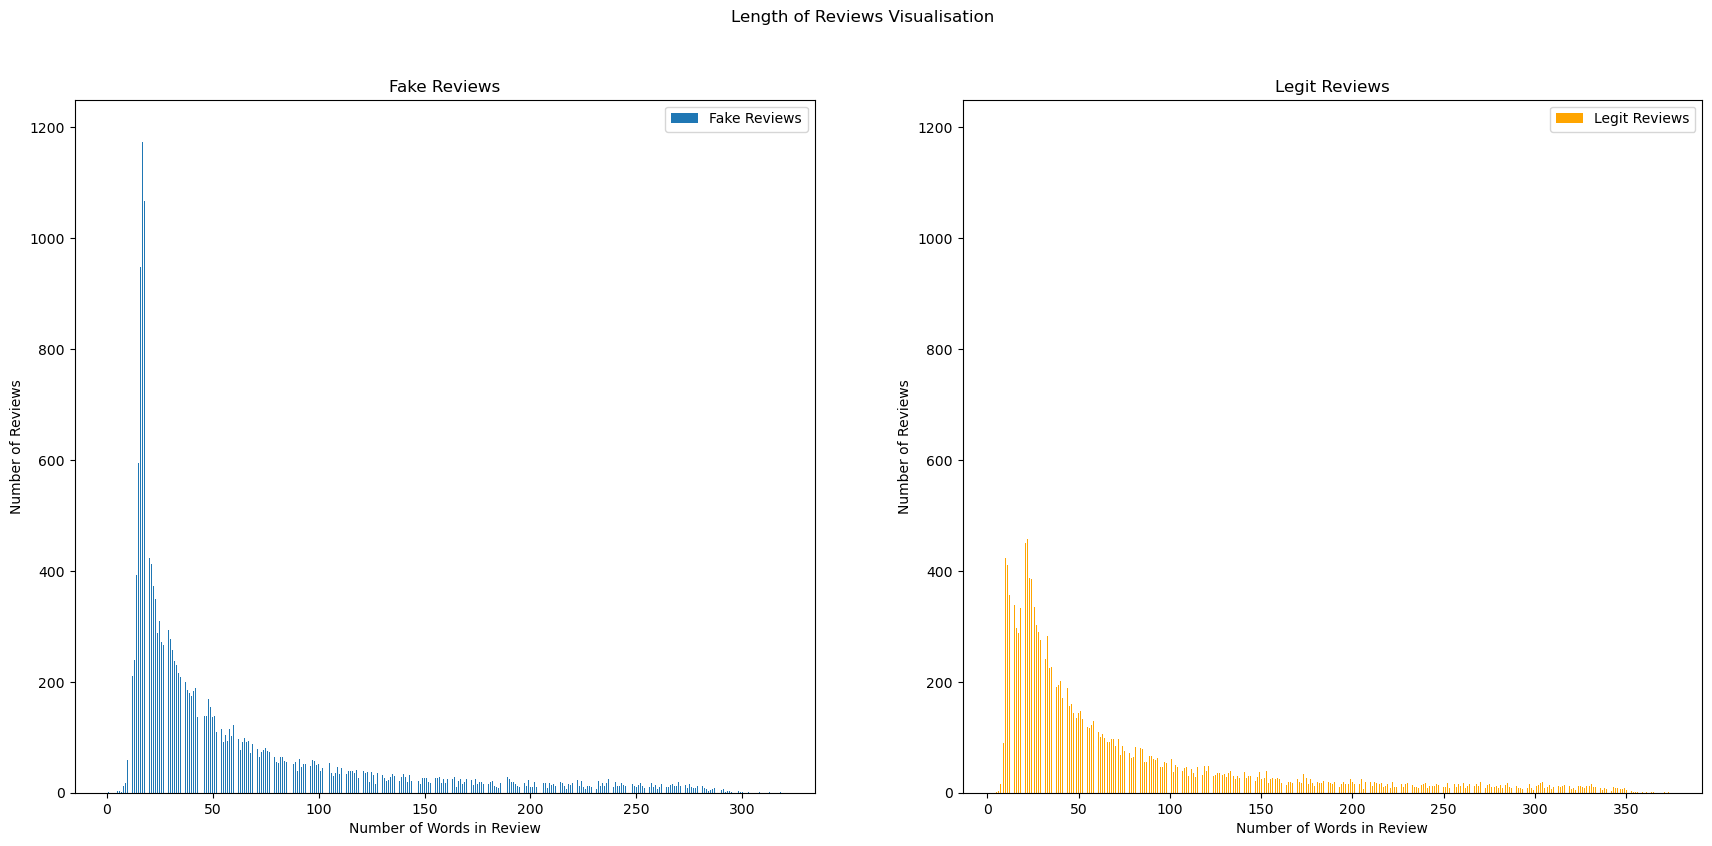

<Figure size 4000x2000 with 0 Axes>

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(21, 9))
plt.figure(figsize=(40,20))
fig.suptitle("Length of Reviews Visualisation")

valuesReviewTxtLenCG = dataFrame["reviewText"].loc[dataFrame["label"] == "CG"].apply(lambda x: len(x.split())).value_counts()
labelsReviewTxtLenCG = valuesReviewTxtLenCG.keys()
axs[0].bar(labelsReviewTxtLenCG,valuesReviewTxtLenCG, width=0.4, label="Fake Reviews")
axs[0].set_ylim(0,1250)
axs[0].set_ylabel("Number of Reviews")
axs[0].set_xlabel("Number of Words in Review")
axs[0].set_title("Fake Reviews")
axs[0].legend()

valuesReviewTxtLenOR = dataFrame["reviewText"].loc[dataFrame["label"] == "OR"].apply(lambda x: len(x.split())).value_counts()
labelsReviewTxtLenOR = valuesReviewTxtLenOR.keys()
axs[1].bar(labelsReviewTxtLenOR,valuesReviewTxtLenOR,width=0.4, color="orange", label="Legit Reviews")
axs[1].set_ylim(0,1250)
axs[1].set_ylabel("Number of Reviews")
axs[1].set_xlabel("Number of Words in Review")
axs[1].set_title("Legit Reviews")
axs[1].legend()

plt.show()

Comments: Based on the above figures, one can clearly see that a lot of the fake reviews are under 25 words. Wheras the 

Preprocess data

In [33]:
def cleanText(text):
    text = text.lower()
    text = ' '.join([word for word in nltk.word_tokenize(text) if word not in stopwords.words('english') and not word.isdigit() and word not in string.punctuation])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [34]:
dataFrame["reviewText"].head()

1    Love this!  Well made, sturdy, and very comfor...
2    love it, a great upgrade from the original.  I...
3    This pillow saved my back. I love the look and...
4    Missing information on how to use it, but it i...
5    Very nice set. Good quality. We have had the s...
Name: reviewText, dtype: object

In [35]:
dataFrame["reviewText"].head().apply(cleanText)

1       love well made sturdy comfortable love pretty
2    love great upgrade original 've mine couple year
3             pillow saved back love look feel pillow
4         missing information use great product price
5                 nice set good quality set two month
Name: reviewText, dtype: object

In [22]:
dataFrame["type"] = np.where(dataFrame["label"] == "CG", 1, 0)
dataFrame["reviewText"] = dataFrame["reviewText"].apply(cleanText)
dataFrame.to_csv('preprocessed_fake_reviews_dataset.csv')

Create testing data

In [23]:
X = dataFrame['reviewText']
Y = dataFrame['label']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, train_size=0.8, random_state=seed, shuffle=True)

Bag of word

In [24]:
X_train.shape

(32345,)

In [44]:
dataFrame = pd.read_csv('preprocessed_fake_reviews_dataset.csv')

dataFrame = dataFrame.dropna()

X = dataFrame['reviewText']
Y = dataFrame['label']



In [ ]:
trainData, testData, trainLabels, testLabels = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=seed, shuffle=True)

In [45]:
testData.shape

(8087,)

In [46]:
validationData, trainData, validationLabels, trainLabels = train_test_split(trainData, trainLabels, train_size=0.1, test_size=0.9, shuffle=True)

In [47]:
validationData.shape

(3234,)

In [48]:
trainData.shape

(29110,)

In [49]:
classifiers = {}
classifiers.update({"RandomForestClassifier": RandomForestClassifier()})
classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiers.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiers.update({"SVMClassifier": SVC()})
classifiers.update({"MLPClassifier": MLPClassifier()})

In [62]:
#Hyperparameters to controll for each model
paramsLst = [
    {   #RandomForest
        'clf__n_estimators': [8,7,6,5,4,3,2,1],
        'clf__max_depth': [2,4,6,8,10,12,14,16]
    },


    {   #AdaBoost
        'clf__n_estimators': [10,20,30,40,50,60,70,75,80],
        'clf__learning_rate': [0,1,3,6,12,15,18,21,25]
    },

    {   #KNN
        'clf__n_neighbors': [1,3,5,7,10,12,13,14],
        'clf__p': [1,2]
    },

    {   #SVM
        'clf__kernel': ["linear", "poly", "rbf"],
        'clf__C': [0.1,2,3,5,7,10,12,14,16]
    },

    {   #MLP
        'clf__hidden_layer_sizes': [(4,2),(6,3),(6,4),(8,4),(10,5),(15,5),(15,10),(20,10),(30,15)],
        'clf__learning_rate': ["constant", "invscaling", "adaptive"]
    }
]


In [63]:

#Supress warnings from sqlearn
warnings.simplefilter("ignore")

index = 0 
bestParamLst = []
for key in classifiers:
    pipeline = Pipeline([("bagOfWords", bagOfWordsVectorizer), ("clf", classifiers[key])])

    grid_search = GridSearchCV(pipeline, paramsLst[index], cv=3)
    grid_search.fit(validationData, validationLabels)

    print(grid_search.best_params_)
    print(grid_search.best_score_)
    print("\n")
    
    bestParamLst.append(grid_search.best_params_)
    index += 1

{'clf__max_depth': 14, 'clf__n_estimators': 8}
0.6982065553494126


{'clf__learning_rate': 1, 'clf__n_estimators': 75}
0.7405689548546691


{'clf__n_neighbors': 13, 'clf__p': 2}
0.6110080395794681


{'clf__C': 0.1, 'clf__kernel': 'linear'}
0.8027210884353742


{'clf__hidden_layer_sizes': (8, 4), 'clf__learning_rate': 'invscaling'}
0.7755102040816326




In [71]:
resultLst = []
for key, i in zip(classifiers, range(0,len(bestParamLst))):
    pipeline = Pipeline([("bagOfWords", bagOfWordsVectorizer), ("clf", classifiers[key])])
    pipeline.set_params(**bestParamLst[i])
    pipeline.fit(trainData,trainLabels)
    predictedLabels = pipeline.predict(testData)
    resultLst.append(predictedLabels)    

In [72]:
for i in range(len(resultLst)):
    print('acc', np.mean(resultLst[i] == testLabels) * 100)
    print("\n")

acc 68.57920118709039


acc 75.70174353901324


acc 63.49697044639545


acc 86.43501916656362


acc 82.92321009026833




In [83]:
classifiersTFIDF = {}
classifiersTFIDF.update({"RandomForestClassifier": RandomForestClassifier()})
classifiersTFIDF.update({"AdaBoostClassifier": AdaBoostClassifier()})
classifiersTFIDF.update({"KNeighborsClassifier": KNeighborsClassifier()})
classifiersTFIDF.update({"SVMClassifier": SVC()})
classifiersTFIDF.update({"MLPClassifier": MLPClassifier()})

In [86]:
#Supress warnings from sqlearn
warnings.simplefilter("ignore")

index = 0 
bestParamLst = []
for key in classifiersTFIDF:
    pipeline = Pipeline([("tfidf", tfidfVectorizer), ("clf", classifiersTFIDF[key])])

    grid_search = GridSearchCV(pipeline, paramsLst[index], cv=3)
    grid_search.fit(validationData, validationLabels)

    print(grid_search.best_params_)
    print(grid_search.best_score_)
    print("\n")
    
    bestParamLst.append(grid_search.best_params_)
    index += 1

{'clf__max_depth': 16, 'clf__n_estimators': 8}
0.712121212121212


{'clf__learning_rate': 1, 'clf__n_estimators': 80}
0.7498453927025356


{'clf__n_neighbors': 1, 'clf__p': 2}
0.6032776747062462


{'clf__C': 3, 'clf__kernel': 'rbf'}
0.8215831787260358


{'clf__hidden_layer_sizes': (6, 3), 'clf__learning_rate': 'constant'}
0.8027210884353742




In [87]:
resultLstTFIDF = []
for key, i in zip(classifiersTFIDF, range(0,len(bestParamLst))):
    pipeline = Pipeline([("tfidf", tfidfVectorizer), ("clf", classifiersTFIDF[key])])
    pipeline.set_params(**bestParamLst[i])
    pipeline.fit(trainData,trainLabels)
    predictedLabels = pipeline.predict(testData)
    resultLstTFIDF.append(predictedLabels)   

In [88]:
for i in range(len(resultLstTFIDF)):
    print('acc', np.mean(resultLstTFIDF[i] == testLabels) * 100)
    print("\n")

acc 71.80660319030542


acc 78.49635217014962


acc 64.25126746630394


acc 89.01941387411895


acc 80.09150488438235




In [ ]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'acc'])
for key in classifiers:

    start_time = time.time()
    pipeline = Pipeline([("bagOfWords", bagOfWordsVectorizer), ("clf", classifiers[key] )])
    pipeline.fit(trainData, trainLabels)
    predictedLabels = pipeline.predict(testData)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'acc': np.mean(predictedLabels == testLabels)
    }

    df_models = df_models.append(row, ignore_index=True)

df_models = df_models.sort_values(by='acc', ascending=False)
df_models